In [ ]:
import csv
import time
import torch
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from cartoon_gan_origin.models.generator import Generator  


@torch.no_grad()
def benchmark_model(model, device, batch_sizes, image_size, warmup = 0, iters = 50):
    results = []

    model.to(device)
    model.eval()

    if device.type == "cuda":
        torch.cuda.empty_cache()
        torch.backends.cudnn.benchmark = True

    for batch_size in batch_sizes:
        dummy_input = torch.randn(batch_size, 3, image_size[0], image_size[1], device=device)

        # WARMUP for compile
        for _ in range(warmup):
            _ = model(dummy_input)

        # TIMING
        times = []
        for _ in tqdm(range(iters)):
            start = time.time()
            _ = model(dummy_input)
            times.append(time.time() - start)

        avg_time = sum(times) / len(times)
        throughput = batch_size / avg_time
        results.append({
            "device": device.type,
            "batch_size": batch_size,
            "avg_time_sec": avg_time,
            "throughput_fps": throughput,
        })
        print(f"{device.type} batch={batch_size} avg_time={avg_time*1000}ms throughput={throughput}img/s")

    return results

## Default model test

In [58]:
WEIGHTS = 'cartoon_gan_origin/checkpoints/trained_netG.pth'
BATCH_SIZE = [1, 2, 4, 8, 16, 32, 64]
IMG_SIZE = (128, 128)

model = Generator()
model.load_state_dict(torch.load(WEIGHTS, map_location='cpu'))

cpu_stats, gpu_stats = [], []

In [59]:
# CPU TEST
cpu_device = torch.device("cpu")
cpu_stats = benchmark_model(model, cpu_device, BATCH_SIZE, IMG_SIZE)
print('cpu test finish')

100%|██████████| 50/50 [00:03<00:00, 13.31it/s]


cpu batch=1 avg_time=74.66670036315918ms throughput=13.392851098766426img/s


100%|██████████| 50/50 [00:07<00:00,  6.99it/s]


cpu batch=2 avg_time=142.08181858062744ms throughput=14.0763964029997img/s


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


cpu batch=4 avg_time=269.93494987487793ms throughput=14.818384954797839img/s


100%|██████████| 50/50 [00:26<00:00,  1.89it/s]


cpu batch=8 avg_time=526.8943214416504ms throughput=15.183310342216206img/s


100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


cpu batch=16 avg_time=1049.7218036651611ms throughput=15.242133624485195img/s


100%|██████████| 50/50 [01:50<00:00,  2.22s/it]


cpu batch=32 avg_time=2215.7338762283325ms throughput=14.442167601134054img/s


100%|██████████| 50/50 [03:34<00:00,  4.29s/it]

cpu batch=64 avg_time=4286.589813232422ms throughput=14.930283229441779img/s
cpu test finish


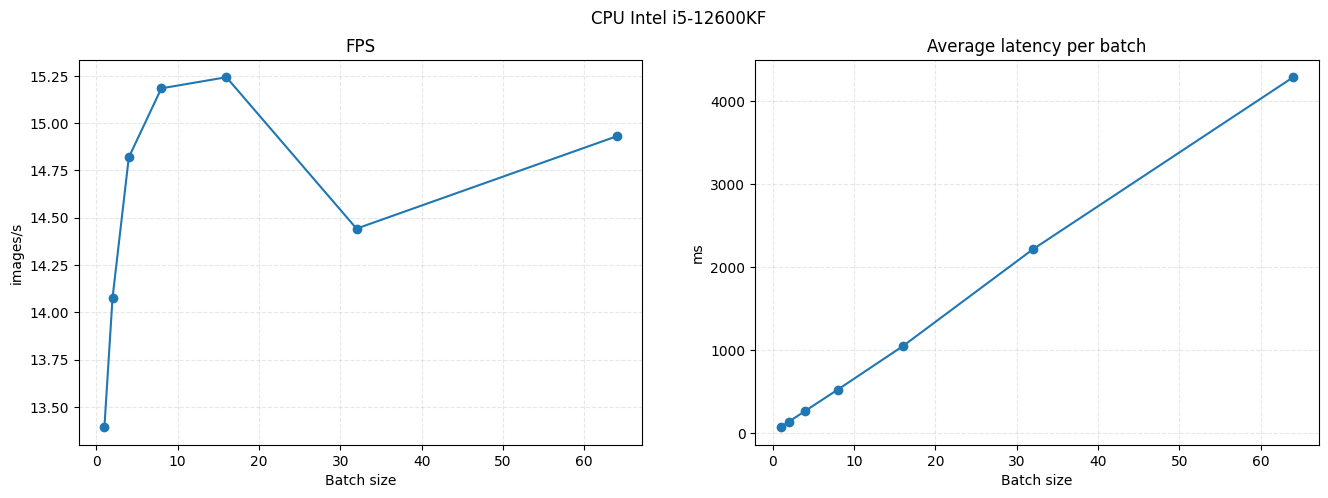

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

fig.suptitle('CPU Intel i5-12600KF')
ax[0].plot(BATCH_SIZE, [d["throughput_fps"] for d in cpu_stats], marker="o")
ax[0].set_title('FPS')
ax[0].set_xlabel('Batch size')
ax[0].set_ylabel('images/s')
ax[0].grid(linestyle="--", alpha=0.3)

ax[1].plot(BATCH_SIZE, [d["avg_time_sec"] * 1000 for d in cpu_stats], marker="o")
ax[1].set_title('Average latency per batch')
ax[1].set_xlabel('Batch size')
ax[1].set_ylabel('ms')
ax[1].grid(linestyle="--", alpha=0.3)


In [61]:
# GPU TEST
BATCH_SIZE = [1, 2, 4, 16, 32, 64, 128]
IMG_SIZE = (128, 128)

assert torch.cuda.is_available()
gpu_device = torch.device("cuda")
model.to(gpu_device)

gpu_stats = benchmark_model(model, gpu_device, BATCH_SIZE, IMG_SIZE, iters=200)

100%|██████████| 200/200 [00:00<00:00, 421.66it/s]


cuda batch=1 avg_time=2.3521339893341064ms throughput=425.1458482104167img/s


100%|██████████| 200/200 [00:00<00:00, 232.18it/s]


cuda batch=2 avg_time=4.272251129150391ms throughput=468.1372745983062img/s


100%|██████████| 200/200 [00:01<00:00, 123.89it/s]


cuda batch=4 avg_time=8.013029098510742ms throughput=499.1870054163934img/s


100%|██████████| 200/200 [00:07<00:00, 26.79it/s]


cuda batch=16 avg_time=37.10495710372925ms throughput=431.20923048828735img/s


100%|██████████| 200/200 [00:17<00:00, 11.68it/s]


cuda batch=32 avg_time=85.22266626358032ms throughput=375.48696142677613img/s


100%|██████████| 200/200 [00:34<00:00,  5.82it/s]


cuda batch=64 avg_time=171.20039343833923ms throughput=373.83091659220224img/s


100%|██████████| 200/200 [01:08<00:00,  2.94it/s]

cuda batch=128 avg_time=339.84474062919617ms throughput=376.64258026479365img/s


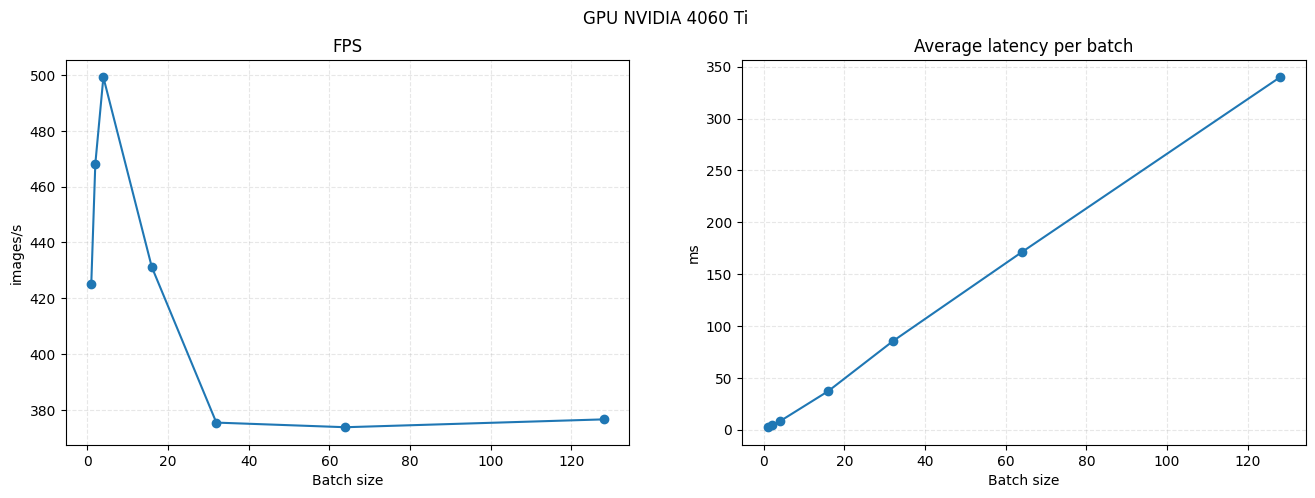

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

fig.suptitle('GPU NVIDIA 4060 Ti')
ax[0].plot(BATCH_SIZE, [d["throughput_fps"] for d in gpu_stats], marker="o")
ax[0].set_title('FPS')
ax[0].set_xlabel('Batch size')
ax[0].set_ylabel('images/s')
ax[0].grid(linestyle="--", alpha=0.3)

ax[1].plot(BATCH_SIZE, [d["avg_time_sec"] * 1000 for d in gpu_stats], marker="o")
ax[1].set_title('Average latency per batch')
ax[1].set_xlabel('Batch size')
ax[1].set_ylabel('ms')
ax[1].grid(linestyle="--", alpha=0.3)

In [64]:
all_stats = cpu_stats + gpu_stats

with open("test_results/benchmark_results.csv", "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["device", "batch_size", "avg_time_sec", "throughput_fps"])
    writer.writeheader()
    writer.writerows(all_stats)